# Bag of Words Sentiment Analyse von McDonalds Reviews

## Zielsetzung:
Die Reviews haben die Labels '1 star', '2 stars', '3 stars', '4 stars' und '5 stars'. 
Das reine Raten, wie der Reviewer bewertet hat, würde eine 20% Prozentige Trefferwahrscheinlichkeit haben. Dieses Benchmarkt muss unsere Analyse mindestens knacken um Sinnvoll zu sein. 

Alle Imports:

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow import keras
from tensorflow.keras import layers


## Datenvorbereitung inkl. Behandlung bekannter Probleme

### Laden der Daten

In [2]:
%pip install kaggle
!kaggle datasets download -d nelgiriyewithana/mcdonalds-store-reviews
!unzip mcdonalds-store-reviews.zip


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
 56%|█████████████████████▎                | 1.00M/1.78M [00:00<00:00, 1.63MB/s]
100%|██████████████████████████████████████| 1.78M/1.78M [00:00<00:00, 2.57MB/s]
Archive:  mcdonalds-store-reviews.zip
  inflating: McDonald_s_Reviews.csv  


In [4]:
df = pd.read_csv('McDonald_s_Reviews.csv', encoding="latin-1")
df.head()

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


### Encoding der Daten


#### Umgang mit Strings als Label
Star Ratings werden gerade noch als 1 Star String bis zu einem 5 star String gespeichert. Mit einem numerischen System können neuronale Netzwerke besser umgehen, deshalb formatiere ich die labels zu interges zwischen 1 und 5.

In [5]:
train_data = df['review'].to_numpy()
label_data_strings = df['rating']
label_data = np.array([int(item.split()[0]) for item in label_data_strings])

### Aufteilung in Trainings und Validierungsdaten 

In [6]:
train_data, test_data, train_label, test_label = train_test_split(train_data, label_data, test_size=0.2, random_state=42)

print(train_data.shape)
print(test_data.shape)
print(train_label.shape)
print(test_label.shape)

(26716,)
(6680,)
(26716,)
(6680,)


### Text zu Dictonary Repräsentationen umbauen
Erklärung Menge an Tokens
Erklärung ngrams 
Erklärung multi_hot und warum

In [11]:
text_vectorization = TextVectorization(
 max_tokens=30000,
ngrams=3,
 output_mode="multi_hot",
)

In [12]:
text_vectorization.adapt(train_data) 
text_vectorization.adapt(test_data) 

multi_hot_train_data = text_vectorization(train_data)
multi_hot_test_data = text_vectorization(test_data)

### Hot Encoding der Lables

In [13]:
train_label_one_hot = tf.one_hot(train_label, 5)
train_label_one_hot.shape

TensorShape([26716, 5])

## Erstellung eines entsprechenden künstlichen neuronalen Models sowie geeigente Benchmarks

In [1]:
def get_model(max_tokens=30000, hidden_dim=64):
 inputs = keras.Input(shape=(max_tokens,))
 x = layers.Dense(hidden_dim, activation="relu")(inputs)
 x = layers.Dense(32, activation="relu")(x)
 x = layers.Dropout(0.5)(x)
 x = layers.Dense(16, activation="relu")(x)
 outputs = layers.Dense(5, activation="softmax")(x)
 model = keras.Model(inputs, outputs)
 model.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"], 
 )
 return model

model = get_model()
model.summary()


2023-06-27 18:31:23.171430: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30000)]           0         
                                                                 
 dense (Dense)               (None, 16)                480016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 480,033
Trainable params: 480,033
Non-trainable params: 0
_________________________________________________________________


## Durchführung von In-sample und Out-of-sample Prognosen sowie Bestimmungen sowie Bestimmung der Prognossegüter anhand geeigneter Metriken 

In [2]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",  # Metric to monitor
        patience=3,  # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True,  # Restore the weights of the best epoch
    )
]
history = model.fit(multi_hot_train_data,train_label_one_hot,
validation_split=0.4,
 epochs=10, 
 callbacks= callbacks
 )

NameError: name 'multi_hot_train_data' is not defined

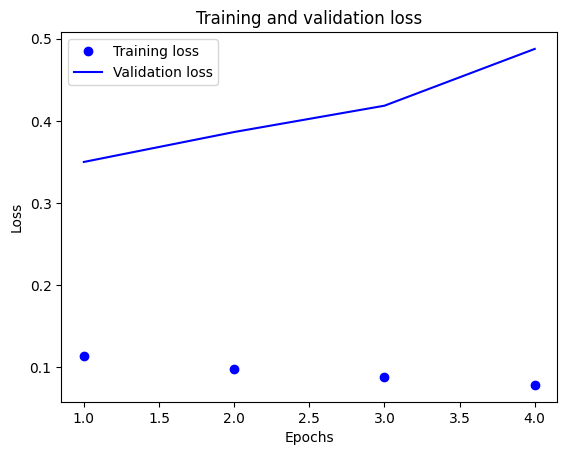

In [36]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [38]:
test_label_one_hot = tf.one_hot(test_label, 5)
model.evaluate(multi_hot_test_data,test_label_one_hot)

  1/209 [..............................] - ETA: 8s - loss: 0.5951 - accuracy: 0.3750

209/209 [==============================] - 1s 4ms/step - loss: 0.3613 - accuracy: 0.4596


[0.36131736636161804, 0.45958083868026733]

## Fazit

Wir kommen auf Out-of Samlple accuracy von 45%. Als Ziel haben wir uns 20 % Prozent gesetzt, weil wir 5 verschiedene Lables haben und alles drunter nur Raten wäre. Somit hat unsere Analyse das Ziel erreicht.